In [1]:
import nest
import network
import addons
import numpy as np
from network_params import net_dict
import network_params
from sim_params import sim_dict
from stimulus_params import stim_dict
from scipy.signal import argrelextrema
import nest
import pickle
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



/home/hyc_1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning:Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


In [2]:
def filter_signal(data,fs,lowcut,highcut,order=3):

    return addons.butter_bandpass_filter(data,lowcut,highcut,fs,order)

In [3]:
def filter_signal(data,fs,lowcut,highcut,order=3):

    return addons.butter_bandpass_filter(data,lowcut,highcut,fs,order)

In [4]:
from scipy import signal
from scipy.signal import butter, lfilter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def compute_FFT(signal_data,freq_sample= 0.001,freq_sample_welsh = 1000,lim_y = 7000, lim_x = 200, low_log = 10, high_log =90,fit=False,fit_freq_start = 5, fit_freq_end = 25,test_p0 = [1,10,2],welsh_fit = 'alpha',signal_xmin=950,signal_xmax=1050,save=True,name_='freq.dat',plot=True,p0 =[1000,80,5]):


    bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
    bg_rates = [6.0,8.0]
    #analysis_interval_start = 0
    #analysis_interval_end = 999
    FFT_Results = {}
    Welsh_Freqs = {}
    time_pop = np.linspace(950,1450,num=int((1450-950)/0.2))
    Welsh_Powers = {}
    if fit:
        Fit_FFT = {}
        Fit_Welsh = {}
        mean_freq = []
        mean_welsh = []
        amplitude_freq = []
        amplitude_welsh = []
        sigma_freq = []
        sigma_welsh = []
        def gaus(x, a, x0, sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))


    for i in range(len(signal_data)):
        FFT_Results[i] = fft(signal_data[i]-np.mean(signal_data[i]))
        Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(signal_data[i]-np.mean(signal_data[i]),fs=freq_sample_welsh)
        #FFT_Results[i] = fft(signal_data[i][analysis_interval_start:analysis_interval_end])
        #Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(signal_data[i][analysis_interval_start:analysis_interval_end],fs=freq_sample_welsh)

    #Calcular los valores de frequencia correspondientes
    #freq = fftfreq(len(signal_data[i][analysis_interval_start:analysis_interval_end]),d=freq_sample) * 1000
    freq = fftfreq(len(signal_data[i]),d=freq_sample)
    if fit:
        index_start = int(np.argwhere(np.abs(freq-fit_freq_start)<2)[0][0])
        index_end = int(np.argwhere(np.abs(freq-fit_freq_end)<2)[0][0])

    if plot:
        plt.figure(figsize=(25, 7))
        colors = ['#e3342f', '#f6993f', '#ffed4a', '#38c172', '#4dc0b5', '#3490dc', '#6574cd', '#9561e2', '#f66d9b','pink', 'black', 'gray', 'brown', 'lightblue', 'lightgreen']
        # Graficar la amplitud en función de la frecuencia

        plt.subplot(1, 4, 1)
        j= 0
        for i in range(len(signal_data)):
            plt.plot(time_pop,signal_data[i], c = colors[j], label = i)
            j=j+1
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('Signal')
        plt.xlim(signal_xmin,signal_xmax)    
        plt.grid(True)
        #plt.legend(loc= 'best')

        plt.subplot(1, 4, 2)
    j= 0

    indx = int(len(signal_data[i])/2)
    for i in FFT_Results:
        if fit:
            Fit_FFT[i], __ = curve_fit(gaus,freq[index_start:index_end],np.abs(FFT_Results[i][index_start:index_end]),p0 = test_p0)
            mean_freq = np.append(mean_freq,Fit_FFT[i][1])
            amplitude_freq = np.append(amplitude_freq,Fit_FFT[i][0])
            sigma_freq = np.append(sigma_freq,Fit_FFT[i][2])

            if plot:
                plt.plot(freq[index_start:index_end],gaus(freq[index_start:index_end],*Fit_FFT[i]),'--', c = colors[j])
        if plot:
            plt.plot(freq[:indx], np.abs(FFT_Results[i])[:indx],c = colors[j])
        j=j+1
    if plot:
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title('Voltage (minus the mean) FFT')
        plt.grid(True)
        plt.xlim(1,lim_x)
        plt.ylim(0,lim_y)
        plt.legend(loc= 'best')

        plt.subplot(1, 4, 3)
    j= 0
    indx = int(len(signal_data[i])/2)
    for i in FFT_Results:
        if fit:
            if plot:
                plt.plot(freq[index_start:index_end],20 * np.log10(gaus(freq[index_start:index_end],*Fit_FFT[i])),'--', c = colors[j])
        if plot:
            plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results[i])[:indx]),c = colors[j], label = bg_rates[i])
        j=j+1
    if plot:
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (dB)')
        plt.title('Voltage (minus the mean) FFT')
        plt.grid(True)
        plt.xlim(1,lim_x)
        plt.ylim(low_log,high_log)
        plt.legend(loc= 'best')

        plt.subplot(1, 4, 4)
    j= 0

    #plt.ylim([0.5e-3, 1])
    for i in Welsh_Freqs:
        if fit:
            if welsh_fit == 'alpha':
                i_start = int(np.where((Welsh_Freqs[i] < 4) & (Welsh_Freqs[i] > 0.0))[0][0])
                i_end = int(np.where((Welsh_Freqs[i]<35.0) & (Welsh_Freqs[i] >27.0))[0][0])

            if welsh_fit == 'gamma':
                i_start = int(np.where((Welsh_Freqs[i] <40 ) & (Welsh_Freqs[i] > 25.0))[0][0])
                i_end = int(np.where((Welsh_Freqs[i]<140.0) & (Welsh_Freqs[i] >120.0))[0][0])

        if fit:
            Fit_Welsh[i], __ = curve_fit(gaus,Welsh_Freqs[i][i_start:i_end],Welsh_Powers[i][i_start:i_end],p0 = p0)
            mean_welsh = np.append(mean_welsh,Fit_Welsh[i][1])
            amplitude_welsh = np.append(amplitude_welsh,Fit_Welsh[i][0])
            sigma_welsh = np.append(sigma_welsh,Fit_Welsh[i][2])
            if plot:
                plt.plot(Welsh_Freqs[i][i_start:i_end],gaus(Welsh_Freqs[i][i_start:i_end],*Fit_Welsh[i]),'--', c = colors[j])
        if plot:
            plt.plot(Welsh_Freqs[i], Welsh_Powers[i],c = colors[j],label=bg_rates[i])
        j=j+1
    if plot:
        plt.xlabel('Frequency [Hz]')
        plt.ylabel(r'PSD $[V^2/Hz]$')
        plt.title('Voltage (minus the mean) Welch')
        plt.grid(True)
    #plt.legend(loc= 'best')
        plt.tight_layout()
        plt.xlim(1,lim_x)
        plt.ylim(1e-5, 1e5)
        plt.yscale('log')
        #plt.xscale('log')
        plt.show()

    if save:
        if fit:
            mean_final = np.mean( np.array([mean_freq,mean_welsh]),axis= 0)
            amplitude_final = np.mean( np.array([amplitude_freq,amplitude_welsh]),axis= 0)
            sigma_final = np.mean( np.array([sigma_freq,sigma_welsh]),axis= 0)
        else: 
            mean_final = np.zeros(len(bg_rates))
            amplitude_final = np.zeros(len(bg_rates))
            sigma_final = np.zeros(len(bg_rates))
        pops = [0,1,2,3,4,5,6,7]


        #np.savetxt(analysis_dict["name"] + name_, np.c_[pops,mean_final, amplitude_final, sigma_final], fmt = '%.2f', header = 'Pops mean_freq amplitude sigma')

    return FFT_Results, freq, Welsh_Freqs, Welsh_Powers, mean_final, amplitude_final, sigma_final

In [5]:
import math 
from scipy.fftpack import *

def hilbert_transform(signal):
    '''
    N : fft length
    M : number of elements to zero out
    U : DFT of signal
    V: IDFT of H(U) 
    '''

    N = len(signal)
    #take the forward Fourier transform
    U = fft(signal)
    M = N - N//2 - 1
    #Zero out negative frequency components
    U[N//2+1:] = [0] * M 
    #double fft energy except #DC0
    U[1:N//2] = 2 * U[1:N//2]
    #take inverse of Fourier transform
    v = ifft(U)
    return v 

In [6]:
import random
import helpers
def prepare_data(data_pop,ex_current_pop,in_current_pop):
    sd_names, node_ids, data = helpers.__load_spike_times(name,"spike_recorder",addons.analysis_dict["analysis_start"], addons.analysis_dict["analysis_end"])
#TODO: FIX THIS
    times = {}
    data_voltages = np.zeros((8,1000))
    data_excitatory = np.zeros((8,1000))
    data_inhibitory = np.zeros((8,1000))
    data_excitatory_sum = np.zeros((8,1000))
    data_inhibitory_sum = np.zeros((8,1000))
    bins = {}

    names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]



    for i in range(len(data_pop)):
        random.shuffle(data_pop[i])
        random.shuffle(ex_current_pop[i])
        random.shuffle(in_current_pop[i])
        data_voltages[i] =  np.mean(data_pop[i][0:1000],axis=0)
        data_excitatory[i] = np.mean(ex_current_pop[i][0:1000],axis=0)
        data_excitatory_sum[i] = np.sum(ex_current_pop[i][0:1000],axis=0)
        data_inhibitory[i] = np.mean(in_current_pop[i][0:1000],axis=0)
        data_inhibitory_sum[i] = np.sum(in_current_pop[i][0:1000],axis=0)
        neurons = np.unique(data[i]["sender"]) 
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_help = data[i][indices]["time_ms"] 
        times[i], bins[names[i]] = np.histogram(data[i][indices]["time_ms"], bins = int(addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"]/addons.analysis_dict["bin_size"]))

    #return data_voltages, times, times_help
    return data_voltages, data_excitatory, data_inhibitory, times, times_help, data_excitatory_sum, data_inhibitory_sum

In [7]:
import random
import helpers
def prepare_data(data_pop,ex_current_pop,in_current_pop):
    sd_names, node_ids, data = helpers.__load_spike_times(name,"spike_recorder",addons.analysis_dict["analysis_start"], addons.analysis_dict["analysis_end"])
#TODO: FIX THIS
    times = {}
    data_voltages = np.zeros((8,1000))
    data_excitatory = np.zeros((8,1000))
    data_inhibitory = np.zeros((8,1000))
    bins = {}

    names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]



    for i in range(len(data_pop)):
        random.shuffle(data_pop[i])
        random.shuffle(ex_current_pop[i])
        random.shuffle(in_current_pop[i])
        data_voltages[i] =  np.mean(data_pop[i][0:1000],axis=0)
        neurons = np.unique(data[i]["sender"]) 
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_help = data[i][indices]["time_ms"] 
        times[i], bins[names[i]] = np.histogram(data[i][indices]["time_ms"], bins = int(addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"]/addons.analysis_dict["bin_size"]))
        random.shuffle(data_pop[i])

        data_voltages[i] =  np.mean(data_pop[i][0:1000],axis=0)
        data_excitatory[i] = np.mean(ex_current_pop[i][0:1000],axis=0)
        data_inhibitory[i] = np.mean(in_current_pop[i][0:1000],axis=0)
        neurons = np.unique(data[i]["sender"]) 
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_help = data[i][indices]["time_ms"] 
        times[i], bins[names[i]] = np.histogram(data[i][indices]["time_ms"], bins = int(addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"]/addons.analysis_dict["bin_size"]))

    #return data_voltages, times, times_help
    return data_voltages, data_excitatory, data_inhibitory

Data will be written to: trials_stimulation/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jun 09 12:47:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(metadata=None, model=iaf_psc_exp, size=1065, first=587

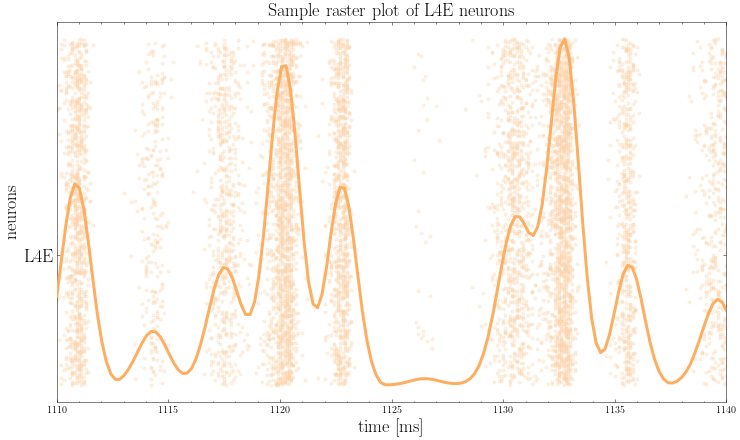

: 

In [ ]:
bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
bg_rates = [16]


times_currents = np.linspace(addons.analysis_dict["analysis_start"],addons.analysis_dict["analysis_end"],num=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/0.2))

number_of_trials = 1

pop_activities_ini = np.zeros((number_of_trials,len(bg_rates),8,len(times_currents)))
volt_currents_ini= np.zeros((number_of_trials,len(bg_rates),8,1000))
ex_currents_ini= np.zeros((number_of_trials,len(bg_rates),8,1000))
in_currents_ini= np.zeros((number_of_trials,len(bg_rates),8,1000))
lowcut_gamma = 50
highcut_gamma = 95

p0_welsh_gamma = [3000000,80,10]
p0_gamma = [30000,80,5]


p0_welsh = [3000000,10,10]
p0 = [30000,10,5]

fit_lim_low = 1
fit_lim_high = 40
fit_lim_low_gamma = 25
fit_lim_high_gamma = 125
lowcut_alpha = 8
highcut_alpha = 15

stim_time = None


mean_alpha_ini = np.zeros((number_of_trials,8,len(bg_rates)))
mean_gamma_ini = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_alpha_ini = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_gamma_ini = np.zeros((number_of_trials,8,len(bg_rates)))


mean_alpha_final_ini = np.zeros((8,len(bg_rates)))
mean_gamma_final_ini = np.zeros((8,len(bg_rates)))
amplitude_alpha_final_ini = np.zeros((8,len(bg_rates)))
amplitude_gamma_final_ini = np.zeros((8,len(bg_rates)))

dev_mean_alpha_final_ini = np.zeros((8,len(bg_rates)))
dev_mean_gamma_final_ini = np.zeros((8,len(bg_rates)))
dev_amp_alpha_final_ini = np.zeros((8,len(bg_rates)))
dev_amp_gamma_final_ini = np.zeros((8,len(bg_rates)))

for l in range(0,number_of_trials):
    for i in range(len(bg_rates)):
        nest.ResetKernel()
        nest.rng_seed = 1234 + l
        net = network.Network(sim_dict, net_dict, stim_dict, path = "trials_stimulation/",stim_time=stim_time)
        net.create(bg_rate=bg_rates[i],rate='fixed')
        net.connect()

        net.simulate(sim_dict["t_presim"])
        net.simulate(sim_dict["t_sim"])
        raster_plot_interval = np.array([1110,1140])
        firing_rates_interval = np.array([900,1500])

        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

        name = "trials_stimulation/"
        neuron_id = np.loadtxt(name + "population_nodeids.dat",dtype=int)
        num_neurons = []
        for j in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
        num_neurons = num_neurons.astype(int)

        voltage_data = addons.load_data(name,"voltmeter",)
        time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
        for j in range(len(num_neurons)):
            data_pop[j] = addons.split_data(voltage_data[j], num_neurons[j])

        del(voltage_data)
        ex_current_data = addons.load_data(name,"ex_current",type="Current")
        for j in range(len(num_neurons)):
            ex_current_pop[j] = addons.split_data(ex_current_data[j],num_neurons[j],type="Current")

        del(ex_current_data)
        in_current_data = addons.load_data(name,"in_current",type="Current")
        for j in range(len(num_neurons)):
            in_current_pop[j] = addons.split_data(in_current_data[j], num_neurons[j],type="Current")
        del(in_current_data)
        volt_currents_ini[l][i], ex_currents_ini[l][i], in_currents_ini[l][i] = prepare_data(data_pop,ex_current_pop,in_current_pop)

        pop_activity, times_a = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=l,raster=False,M=[15,15,15,15,15,15,15,15],std=[3,3,3,3,3,3,3,3],plot=True)
        for k in range(len(pop_activity)):
            pop_activities_ini[l][i][k] = pop_activity[k]



    pop_signal_gamma = np.zeros_like(pop_activities_ini[l])



    for i in range(len(pop_activities_ini[l])):
        for j in range(len(pop_activities_ini[l][i])):
            pop_signal_gamma[i][j] = filter_signal(pop_activities_ini[l][i][j],fs=6000,lowcut=lowcut_gamma,highcut=highcut_gamma)

    test_gamma = pop_signal_gamma.transpose(1,0,2)  

    FFT_power_gamma = {}
    Welsh_power_gamma = {}

    sigma_gamma =np.zeros((len(test_gamma),len(bg_rates)))

    for j in range(len(test_gamma)):
        FFT_power_gamma[j], freq, Welsh_freq, Welsh_power_gamma[j], mean_gamma_ini[l][j][:], amplitude_gamma_ini[l][j][:], sigma_gamma[j][:] = compute_FFT(test_gamma[j],save=True,test_p0 = p0_gamma,lim_x=200,plot=False,freq_sample=0.0002,low_log=40,high_log=125,freq_sample_welsh=5000,fit=True,fit_freq_start=fit_lim_low_gamma,fit_freq_end=fit_lim_high_gamma,welsh_fit='gamma',p0=p0_welsh_gamma)


    pop_signal_alpha = np.zeros_like(pop_activities_ini[l])
    #Filter signal
    for i in range(len(pop_activities_ini[l])):
        for j in range(len(pop_activities_ini[l][i])):
            pop_signal_alpha[i][j] = filter_signal(pop_activities_ini[l][i][j],fs=2000,lowcut=lowcut_alpha,highcut=highcut_alpha)


    test_alpha = pop_signal_alpha.transpose(1,0,2)

    FFT_power_alpha = {}
    Welsh_power_alpha = {}

    sigma_alpha =np.zeros((len(test_alpha),len(bg_rates)))


    for j in range(len(test_alpha)):
        FFT_power_alpha[j], freq, Welsh_freq, Welsh_power_alpha[j], mean_alpha_ini[l][j][:], amplitude_alpha_ini[l][j][:], sigma_alpha[j][:] = compute_FFT(test_alpha[j],save=True,fit=True,test_p0 = [300,10,5],lim_x=100,plot=False,fit_freq_start=fit_lim_low,fit_freq_end=fit_lim_high,welsh_fit='alpha',p0=p0_welsh)



    mean_alpha_final_ini = np.mean(mean_alpha_ini,axis=0)
    amplitude_alpha_final_ini = np.mean(amplitude_alpha_ini,axis=0)
    mean_gamma_final_ini = np.mean(mean_gamma_ini,axis=0)
    amplitude_gamma_final_ini = np.mean(amplitude_gamma_ini,axis=0)

    dev_mean_alpha_final_ini = np.std(mean_alpha_ini,axis=0)
    dev_amp_alpha_final_ini = np.std(amplitude_alpha_ini,axis=0)
    dev_mean_gamma_final_ini = np.std(mean_gamma_ini,axis=0)
    dev_amp_gamma_final_ini = np.std(amplitude_gamma_ini,axis=0)